<p align="center">
 <center> 
 <FONT COLOR="BLUE">
 <strong><font size = '+3.5'>  Salary Prediction of NBA basketball players </font></strong>
   </FONT>
 </center>
</p>

<p align="center">
    <center>
    <img src= "https://i.imgur.com/aTqAM3o.jpg"
    width = 40%;
    height = auto; />
    </center>
</p>

## **Team: 6 Layers of Stonks**
- **Nada Amini** (M2 Data Science_École Polytechnique)
- **Nhat-Minh Dao** (M2 Data Science_École Polytechnique)
- **Fares Feki** (M2 Data Science_École Polytechnique)
- **Juhyun Kim** (M2 Data Science_École Polytechnique)
- **Zongmin Li** (M2 Data Science_École Polytechnique)
- **Thanh-Nam Nguyen** (M2 Data Science_École Polytechnique)

# **Introduction**

<!-- <div class="alert alert-success"> -->
    
**Abstract:** Our project was inspired by these articles *"Estimating NBA players salary share according to their performance on court: A machine learning approach"*, and the article *"Does Racial Discrimination Exist Within the NBA? An analysis Based on Salary-per-Contribution"*. The aim of our project is to present a notebook that predicts the salary of NBA players in term of their characteristics.

**Source of the Dataset:**
- Link: https://figshare.com/articles/dataset/NBA_data/5414170

Actually, at first we focused our attention on the season **2015-2016** to analyse our approach and our methodology and then we added other seasons for comparison purposes and also to perform a new way of cross validating our models.

Our raw data consisted of three seperate databases, that again can be found in the repository:

- *players cv.xlsx* : this dataset contains personal information about players such as the height, the origin, the race...
- *players stat.xlsx* : this dataset contains the statistics concercning the performance of each player.
- *players salary.xlsx* : this dataset contains the names of the players, the teams they play in and their respective salaries.

We cleaned these three datasets separately and then merged them into one big dataset that we'll preprocess and run through our different models. The dataset contains several basketball statistics of the players and a column of the salary of each player. We'll start by giving a brief explanation of each feature of the dataset. More details about the features will be described later on with the plots. We have divided main features in three different groups which are *"Player personal characteristics"*, *"Player general infromation related to games"*, and *"Player performance features"* along with the target feature which is the `Salary`. 

- **Player personal characteristics**
> - `Player`: The name of the player
> - `Age` Age of the player
> - `Tm` Team of the player
> - `Place_of_birth` is the place of birth of the player (it can be a state of the USA and that's why we added the following new column `state_or_country`)
> - `state_or_country` it indicates whether the place of birth is a state of the USA or a country of the world 
> - `Race` Race of the player: Black, White, Black and White or other
> - `Ht`: Height of the player
> - `Wt`: The weight of the player
> - `College`: College to which the player went


- **Player general information related to games**
> - `Pos`: Position in which the player plays on the basketball court
> - `Season`: The season of NBA.
> - `G`: Games. The number of games a player has played in.
> - `GS`: Game Started. It means the number of games in which a player has started in the game.
> - `MP`: Minutes Played


- **Player performance features**
> - `PER`: Player efficiency rating
> - `3APr`: 3-Point Attempt rate
> - `FTr`: Free Throw Attempt rate
> - `ORB%`: Offensive Rebound Percentage
> - `DRB%`: Defensive Rebound Percentage
> - `TRB%`: Total Rebound Percentage
> - `AST%`: Assist Percentage
> - `STL%`: Steal Percentage
> - `BLK%`: Block Percentage
> - `TOV%`: Turnover Percentage
> - `USG%`: Usage Percentage
> - `ORtg`: Offensive Rating
> - `DRtg`: Defensive Rating
> - `OWS`: Offensive Win share
> - `DWS`: Defensive Win share
> - `WS/48`: Win shares per 48 minutes
> - `OBPM`: Offensive Box Plus/Minus
> - `DBPM`: Defensive Box Plus/Minus
> - `BPM`: Box Plus/Minus
> - `VORP`: Value over Replacement Player


- **Target**
> - `SALARY`: Our target variable that we want to predict: the salary of the player


Another idea that popped into our heads for when we will add the other seasons is to take into consideration the factor of inflation in the salaries of the players to make our predictions more accurate.

In [267]:
# Importing the necesarry packages and librairies
import numpy as np
import pandas as pd
import pylab as pl
import copy as cp
import string
import re
import os

import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
pd.set_option('display.max_columns', None)

from helpers import convert_height


%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

As mentioned in the introduction of our project, from the following section, we will first dive into the **2015-2016** season.
With this dataset, we proceed to data visualization, feature engineering and derive conclusions that could be made by analyzing the plots. 

# **Data Analysis and Simple Feature Engineering for the season: 2015-2016**

- In this section, as an illustration of our approach, we first only study on the dataset of the **2015-2016** season. We merge them into one dataframe, then verify duplicated, NaN and irrelevant values. Some simple feature engineering will also be proposed. More advanced techniques about feature engineering will be presented in next sections when dealing with the whole dataset of several seasons.


In [268]:
# Loading the datasets
data_path = "data/"
player_stat = pd.read_excel(os.path.join(data_path, "raw_data", "players stat.xlsx"))
player_cv = pd.read_excel(os.path.join(data_path, "raw_data", "players cv.xlsx"))
player_salary = pd.read_excel(os.path.join(data_path, "raw_data", "players salary.xlsx"))

In [269]:
# Restricting the dataset to the season 2015-2016
player_stat_15_16 = player_stat[player_stat['Season'] == '2015-16']
player_salary_15_16 = player_salary[player_salary['SEASON'] == '2015-2016']
player_cv_15_16 = player_cv[(player_cv['From']<=2016) & (player_cv['To']>=2015)]

In [270]:
print("Player stat:", player_stat_15_16.shape)
print("Player salary:", player_salary_15_16.shape)
print("Player CV:", player_cv_15_16.shape)

Player stat: (476, 29)
Player salary: (416, 5)
Player CV: (566, 10)


## Merging the three datasets

Merging the datasets `player_CV` and `player_stat` was relatively easy in comparison with merging `player_stat` and `player_salary` because the names in both datasets were written in the same format. We used an inner join in order to only take the intersection of players and avoid NaN values.

Moreover, before merging the two dataframes `player_stat_15_16` and `player_cv_15_16`, we have checked if they contain only unique players.

In [271]:
# Merging the datasets player cv and player stat
merge_stat_cv = pd.merge(player_stat_15_16, player_cv_15_16, left_on='Player', right_on='Player', how='inner')

This function below came as a consequence of a manual filtering of the names in the datasets to cover all the exceptions.

In [272]:
# This function helps reformat the names in the player_stat database to the same format of player_salary
def preprocess_name(name):
    if ',' in name:
        ind = name.find(',')
        name = name[:ind]
    ### We remove the Jr.
    if "Jr." in name:
        name = name.replace("Jr.", "")
    if "Jr" in name:
        name = name.replace("Jr.", "")
    if "III" in name:
        name = name.replace("III", "")
    while '.' in name:
        ind = name.find('.')
        name = name.replace('.','')
    name = name.title()
    
    return name

In [273]:
# To be safe, we apply the same name preprocessing function to the two databases 
player_salary_15_16['Player'] = player_salary_15_16['NAME'].apply(lambda s: preprocess_name(s))
merge_stat_cv['Player'] = merge_stat_cv['Player'].apply(lambda s: preprocess_name(s))

# Merging the three datasets
merge_15_16 = pd.merge(merge_stat_cv, player_salary_15_16, left_on='Player', right_on='Player', how='inner')
merge_15_16.shape

(377, 43)

Initially, all the three datasets were almost of size 500 rows. But after doing the intersection and preprocessing we can observe that the size of the database decreased considerably, because some players existed in a database and not in another.

In [274]:
merge_15_16.head()

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
0,Thanasis Antetokounmpo,2015-16,23.0,NYK,NBA,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,2015-2016,416,"Thanasis Antetokounmpo, SF",New York Knicks,30888
1,Stephen Curry,2015-16,27.0,GSW,NBA,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,2015-2016,55,"Stephen Curry, PG",Golden State Warriors,11370786
2,Kevin Durant,2015-16,27.0,OKC,NBA,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,2015-2016,7,"Kevin Durant, SF",Oklahoma City Thunder,20158622
3,Boban Marjanovic,2015-16,27.0,SAS,NBA,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,2015-2016,315,"Boban Marjanovic, C",San Antonio Spurs,1200000
4,Russell Westbrook,2015-16,27.0,OKC,NBA,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",2015-2016,16,"Russell Westbrook, PG",Oklahoma City Thunder,16744218


In [275]:
merge_15_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player          377 non-null    object 
 1   Season          377 non-null    object 
 2   Age             377 non-null    float64
 3   Tm              377 non-null    object 
 4   Lg              377 non-null    object 
 5   G               377 non-null    int64  
 6   GS              377 non-null    float64
 7   MP              377 non-null    float64
 8   PER             377 non-null    float64
 9   3PAr            376 non-null    float64
 10  FTr             376 non-null    float64
 11  ORB%            377 non-null    float64
 12  DRB%            377 non-null    float64
 13  TRB%            377 non-null    float64
 14  AST%            377 non-null    float64
 15  STL%            377 non-null    float64
 16  BLK%            377 non-null    float64
 17  TOV%            376 non-null    flo

In [276]:
# We copy the merged dataframe in order to proceed with safe trials
season_15_16 = merge_15_16.copy()

## **Data Analysis**

### Checking and treating duplicated, missing values 
- In this subsection, we will check if there are any NaN values in the dataframe that we will deal with.
> - By proceeding to the action below, we found out that `3PAr`, `FTr`, `TOV%`, `ORtg`, and `College` have NaN values.
> - In order to treat the NaN values, we either dropped or replaced them, which will be shown below.
> - We do not perform a simple row drop NaN values since more than 20% rows contains at least one NaN values and such operation might cause loss of information in the dataset.

In [277]:
# Checking the number of duplicated rows
print(f"Number of duplicated rows are {season_15_16.duplicated().sum()}")

Number of duplicated rows are 0


In [278]:
# Checking the NaN values
df_null_15_16 =  season_15_16.isnull().sum(axis=0)
df_null_15_16 = df_null_15_16[df_null_15_16>0]
print(f"Below all columns with number of missing values \n{df_null_15_16}")

Below all columns with number of missing values 
3PAr        1
FTr         1
TOV%        1
ORtg        1
College    74
dtype: int64


In [279]:
# Replace NaN values of "College" column to "Missing"
season_15_16["College"] = season_15_16["College"].fillna("Missing")
season_15_16 = season_15_16.dropna(axis=0)
season_15_16.sample(3)

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
161,Jason Thompson,2015-16,29.0,TOT,NBA,47,7.0,471.0,14.2,0.139,0.500,7.9,23.4,15.9,8.5,1.3,3.3,10.2,13.9,119.0,102.0,0.9,0.7,1.6,0.165,-1.3,1.6,0.3,0.3,New Jersey,Black,2009,2016,F-C,6-11,250,"July 21, 1986",Rider University,2015-2016,403,"Jason Thompson, PF",Golden State Warriors,245177
173,Omri Casspi,2015-16,27.0,SAC,NBA,69,21.0,1880.0,13.9,0.441,0.256,3.4,20.1,11.8,7.5,1.4,0.7,12.0,17.8,109.0,108.0,2.1,1.5,3.6,0.092,0.3,-0.6,-0.3,0.8,Israel,White,2010,2016,F,6-9,225,"June 22, 1988",Missing,2015-2016,218,"Omri Casspi, SF",Sacramento Kings,2836186
345,Greivis Vasquez,2015-16,29.0,MIL,NBA,23,0.0,460.0,7.4,0.529,0.188,1.3,10.3,5.8,28.5,1.1,0.0,21.1,18.5,90.0,113.0,-0.4,0.1,-0.3,-0.033,-3.0,-3.9,-6.9,-0.6,Venezuela,Black,2011,2016,G,6-6,217,"January 16, 1987",University of Maryland,2015-2016,106,"Greivis Vasquez, PG",Milwaukee Bucks,6600000


### Remove unneccesary columns

In [280]:
# Drop columns that are redundant or overlapped
to_drop = ['Lg', 'NAME', 'Player', 'SEASON', 'TEAM']
season_15_16 =  season_15_16.drop(to_drop, axis=1)

### Simple feature engineering

1. We convert height from feet and inch to centimeters to have clearer understanding of the units.
2. We created new feature named `seniority` by computing the number of year that the player played in the NBA until the current season.
3. Also, we will see below that since the range of the salary is very large, we decided to create a new feature named `SALARY_CATEGORY` which have three different categories of salaries called `Low`, `Medium`, and `High`.

In [281]:
season_15_16['Ht'] = season_15_16['Ht'].apply(convert_height)

In [282]:
columns_for_seniority = ['To', 'From']
season_15_16['seniority'] = season_15_16[columns_for_seniority].apply(lambda row: row[0] - row[1], axis =1)
season_15_16 = season_15_16.drop(columns_for_seniority, axis=1)
season_15_16.head()

,Season,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,Pos,Ht,Wt,Birth Date,College,RK,SALARY,seniority
0,2015-16,23.0,NYK,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,F,200.66,205,"July 17, 1992",Missing,416,30888,0
1,2015-16,27.0,GSW,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,G,190.50,185,"March 14, 1988",Davidson College,55,11370786,6
2,2015-16,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622,8
3,2015-16,27.0,SAS,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,C,220.98,290,"August 15, 1988",Missing,315,1200000,0
4,2015-16,27.0,OKC,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218,7


In order to divide the salary categories evenly, we have used `qcut`, which will give a balanced division of the three categories.

In [283]:
season_15_16["SALARY_CATEGORY"] = pd.qcut(season_15_16["SALARY"], q=3, labels=['Low', 'Medium', 'High'])

### Convert `Pos`(position of the players) to category

In [284]:
season_15_16["Pos"] = season_15_16["Pos"].astype("category")

In [285]:
# Checking if the positions are all unique
season_15_16["Pos"].unique()

['F', 'G', 'C', 'F-G', 'F-C', 'C-F', 'G-F']
Categories (7, object): ['C', 'C-F', 'F', 'F-C', 'F-G', 'G', 'G-F']

# **Data Visualization**
- We present the EDA following the order of groups of characteristic of player: Target Feature, Personal characteristics, Player general information related to games, performance features.

## Visualization of the target column `SALARY`

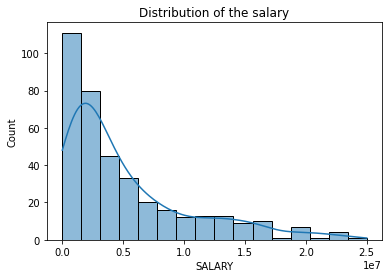

In [286]:
sns.histplot(data=season_15_16, x="SALARY", kde=True)
plt.title('Distribution of the salary')
plt.show()

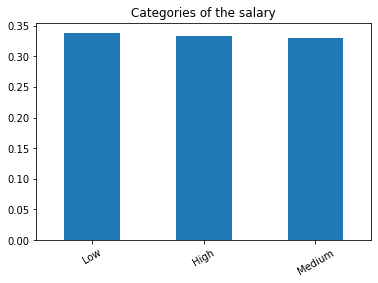

In [287]:
season_15_16['SALARY_CATEGORY'].value_counts(normalize=True).plot.bar()
plt.xticks(rotation=30)
plt.title('Categories of the salary')
plt.show()

## Visualization of **Player personal characteristics**

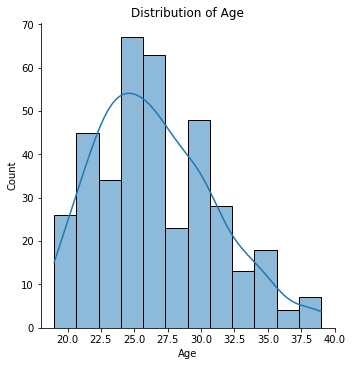

In [288]:
# Distribution of age
sns.displot(x="Age", kde=True, data=season_15_16)
plt.title("Distribution of Age")
plt.show()

- From the boxplot below, we can see that the height of the players are from 180cm to 220cm. Which is higher than the average height of men in USA. And therefore, it is not difficult to understand the information that this feature gives, since tall players will have a lot of advantage to play basketball games. 
- However, in the boxplot below, we see an outlier in the dataset where one player has really lower height than the others.

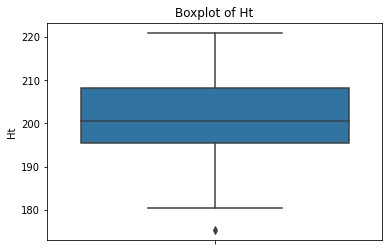

In [289]:
# Checking the range of the height of players
sns.boxplot(y='Ht', data=season_15_16)
plt.title("Boxplot of Ht")
plt.show()

## Visualization of **player general information in games** with respect to  `SALARY`

### Number of games/minutes the player played and his salary (`G` and `MP` w.r.t. `SALARY`)

- Number of games and minutes one player played in the season is an undirect measure for his performance. 
- In general, the longer he played, the more important his role is. As a consequnce, he would obtain a good salary. 

> - The plot below shows the line represention of the mean of salary with respect to the number of game the player already played. 
> - It shows that the curve relatively increases as a function of `G`.


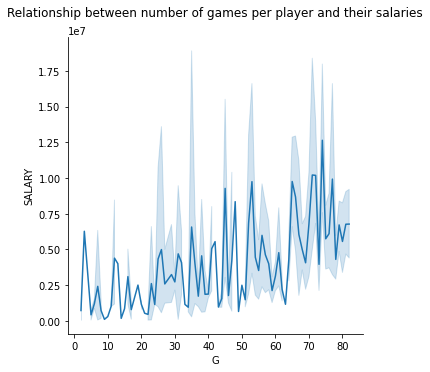

In [290]:
sns.relplot(x="G", y="SALARY", kind="line", data=season_15_16, )
plt.title("Relationship between number of games per player and their salaries"+"\n")
plt.show()

> - Using our new feature `SALARY_CATEGORY` and plotting boxplots for `G`, the phenomena is illustrated much more clearly.

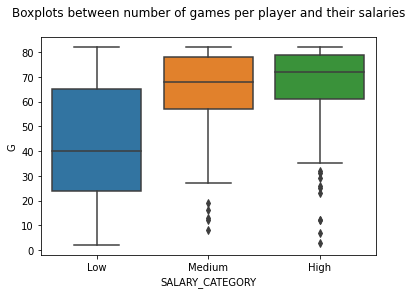

In [291]:
sns.boxplot(y="G", x="SALARY_CATEGORY", data=season_15_16)
plt.title("Boxplots between number of games per player and their salaries"+"\n")
plt.show()

> - Using our new feature `SALARY_CATEGORY` and plotting boxplots for `MP`, we could also see that the players who played more minutes earned higher salaries. Which proves the assupmtion that the one who playes more indicates that they are the skilled players, and they will earn high salaries.

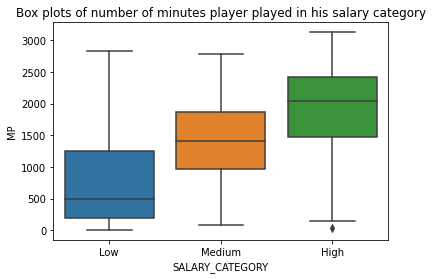

In [292]:
sns.boxplot(y="MP", x="SALARY_CATEGORY", data=season_15_16)
plt.title("Box plots of number of minutes player played in his salary category")
plt.show()

### The seniority of the player and salary (`seniority` w.r.t `SALARY`)

- Here, we additionally defined a new category of seniority called `seniority_category`, which is divided into two different category which is called `Junior` and `Senior`.
- In order to divide the seniority categories evenly, we have used `qcut`, which will give a balanced division of the two categories.
- We will see that the senior players have higher salary than the junior ones.

In [293]:
# Define a new category of seniority
season_15_16["seniority_category"] = pd.qcut(season_15_16["seniority"], q=2, labels=['Junior', "Senior"])

From the barplot below, we can see that the seniors have higher salaries than the juniors.

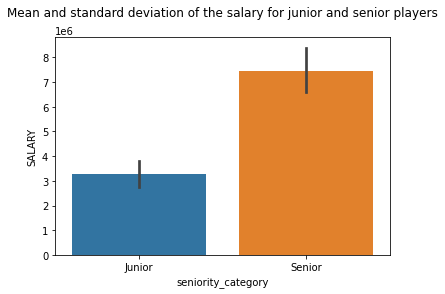

In [294]:
# Plot a barplot to see the mean and standard deviation of the salary for two seniority categories
sns.barplot(x="seniority_category", y="SALARY", data=season_15_16)
plt.title("Mean and standard deviation of the salary for junior and senior players"+"\n")
plt.show()

### Position of the players and salary (`Pos` w.r.t `SALARY`)

- From the barplot below, we could see that in average, the players who play the role between the center position and the forward position earns the most among the other positioned players.

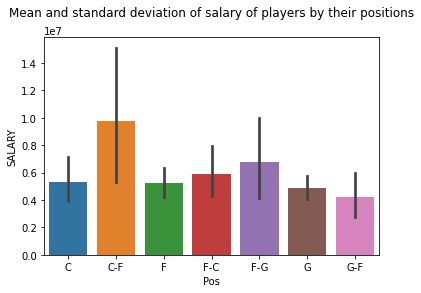

In [295]:
# Plot a barplot to see the mean and standard deviation of the salary of players by their position
sns.barplot(x="Pos", y="SALARY", data=season_15_16)
plt.title("Mean and standard deviation of salary of players by their positions"+"\n")
plt.show()

## Visualization of **Player performance features**

<img src="https://i.imgur.com/WTtPnHp.png"
width = 50%;
height = auto; />

### **PER(Player Efficiency Rate)**

- What actually is PER?
> - PER takes into account <FONT COLOR="BLUE">accomplishments</FONT>, such as field goals, free throws, 3-pointers, assists, rebounds, blocks and steals but also includes player's <FONT COLOR="RED">negative results</FONT> such as missed shots, turnovers and personal fouls.

- From the distribution plot below of the PER(Player Efficiency Rate), 
> - We can see that some players have negative PER which indicates that this player is extremely inefficient.
> - On the contrary, for the players who have a PER of higher than 30 are the ones who have great efficiency.

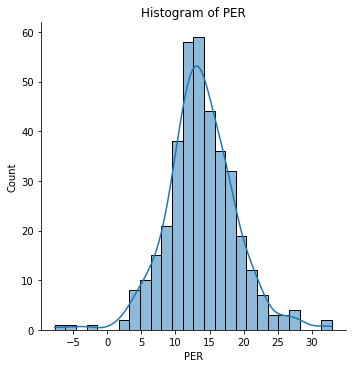

In [296]:
# Checking the distribution of PER
sns.displot(data=season_15_16, x='PER', kde=True)
plt.title("Histogram of PER")
plt.show()

- Using the `SALARY_CATEGORY`:
> - We first visualize the mean PER per salary category as the plot below.
>> - From this, we see that the players who have high PER in average have high salaries, players who have low PER in average have low salaries. 

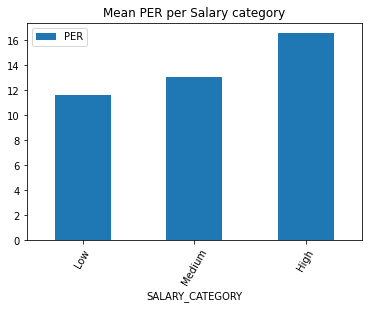

In [297]:
season_15_16.groupby('SALARY_CATEGORY').agg({'PER':np.mean}).plot.bar()
plt.xticks(rotation=60)
plt.title('Mean PER per Salary category')
plt.show()

### **3PAr(3-Point Attempt Rate) and FTr(Free Throw Rate)**

#### - What actually is 3PAr?
> - A player can get a three-point field goal (also 3-pointer) when a field goal in a basketball game was made from beyond the three-point line, a designated arc surrounding the basket.
> - During the game when the player shoot the ball, the 3-Point Attempt Rate is a measure of what % of a player's shots come from long-distance, a three-point field goal among the field goal trials.

- From the distribution plot below of the 3PAr(3-Point Attempt Rate), 
> - We can see that majority of the players have low 3PAr, and only a few players have high rates around 80%.

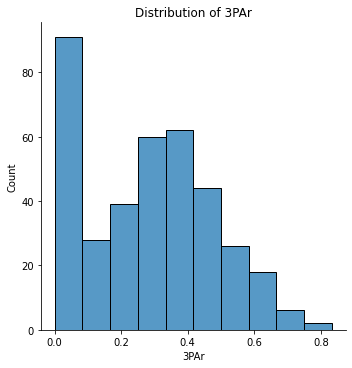

In [298]:
# Checking the distribution of 3PAr
sns.displot(data=season_15_16, x='3PAr')
plt.title('Distribution of 3PAr')
plt.show()

- From the boxplot below, we see that the range of the diviation of the `Low` salary category was higher than the other salary categories.
- Moreover, we see that there weren't any outliers for all three salary categories.

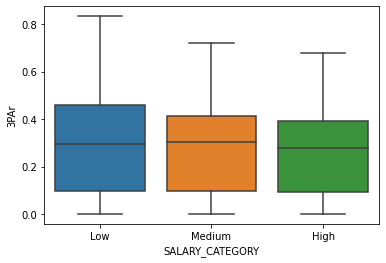

In [299]:
sns.boxplot(x='SALARY_CATEGORY', y='3PAr', data=season_15_16)
plt.show()

#### - What actually is FTr(Free Throw Rate)?
> - A free throw, or foul shot, is an unguarded scoring attempt that a referee awards a basketball player after an opposing team member commits a foul against them, their team, or an official. Free throws provide a basketball team with the opportunity to score points outside of the shot clock during a basketball game.
> - Free Throw Rate is the ratio of Free Throw Attempts to Field Goal Attempts.

- From the distribution plot below of the FTr(Free Throw Rate), 
> - We can see that some players have very high FTr around 80% to 100% which shows the players who have low performance.

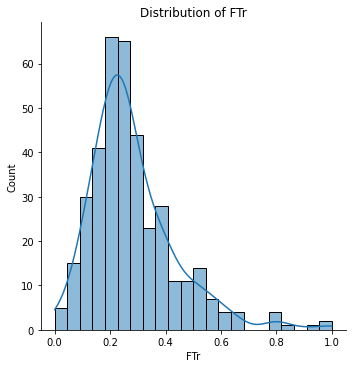

In [300]:
# Checking the distribution of FTr
sns.displot(data=season_15_16, x='FTr', kde=True)
plt.title('Distribution of FTr')
plt.show()

- Using the `SALARY_CATEGORY`:
> - We first visualize the mean FTr per salary category as the plot below.
>> - From this, we see that the players who have high FTr in average have low salaries, players who have low 3PAr in average have high salaries. 

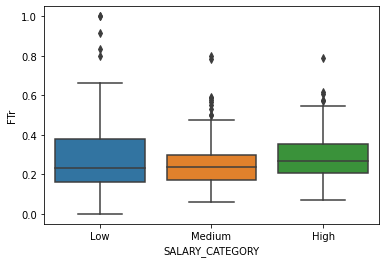

In [301]:
# Boxplot of FTr w.r.t SALARY_CATEGORY
sns.boxplot(x="SALARY_CATEGORY", y = "FTr", data=season_15_16)
plt.show()

### <FONT COLOR="BLUE">**Positive performance features**</FONT>
- **AST%**: Assist Percentage is an estimate of the percentage of teammate field goals a player assisted
- **STL%**: Steal Percentage is an estimate of the percentage of opponent possessions that end with a steal by the player
- **BLK%**: Block Percentage is an estimate of the percentage of opponent two-point field goal attempts blocked by the player

### <FONT COLOR="RED">**Negative performance features**</FONT>
- **TOV%**: Turnover Percentage is an estimate of turnovers committed per 100 plays

The image below is provided to help the understanding of the positions of players in a basketball match.

The basketball player positions are mainly composed as below:
> - Center
> - Point Guard
> - Shooting Guard
> - Small Forward
> - Power Forward

<img src="https://i.imgur.com/2uRXs17.jpg"
width = 45%;
height = auto; />

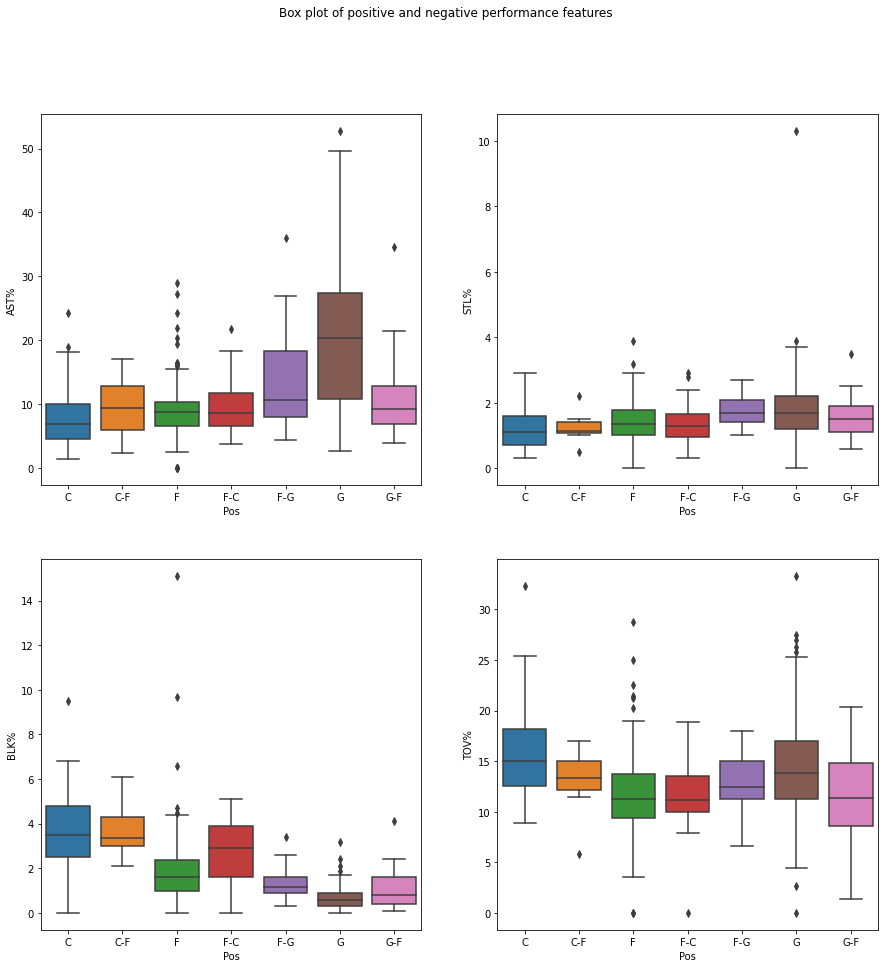

In [302]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Box plot of positive and negative performance features')
sns.boxplot(x='Pos', y='AST%', data=season_15_16, ax=axs[0,0])
sns.boxplot(x='Pos', y='STL%', data=season_15_16, ax=axs[0,1])
sns.boxplot(x='Pos', y='BLK%', data=season_15_16, ax=axs[1,0])
sns.boxplot(x='Pos', y='TOV%', data=season_15_16, ax=axs[1,1])
plt.show()

## **Relationship between various features: `TRB%`, `STL%`, `SALARY`,...**
- In order to see the general relationships between various features, we used the `pairplot` for better visualization.

*Some aspects we can see from the pairplot below:*
> Linear distribution between certain features: 
> - 1. `AST%` and `STL%`: Considering the fact that both `AST%` and `STL%` are positive player performance features, we can see that the player who has higher assist rate also has higher steal rate. This could be assumed by the definition of "assist" in playing basketball in situations when the player steal the ball from the opponent and pass it to their team's player and the player who received the ball shoots a goal. Then the player who passed the ball has "assisted" the goal, and thus will have high `AST%`.
> - 2. `PER` and `ORtg`: Due to the fact that the offensive rating(`ORtg`) is an estimate of points produced by players or scored by teams per 100 possessions, and the PER is a more global parameter that indicates the player's efficiency rate, we could see that the players who produce more points will highly have higher PER.

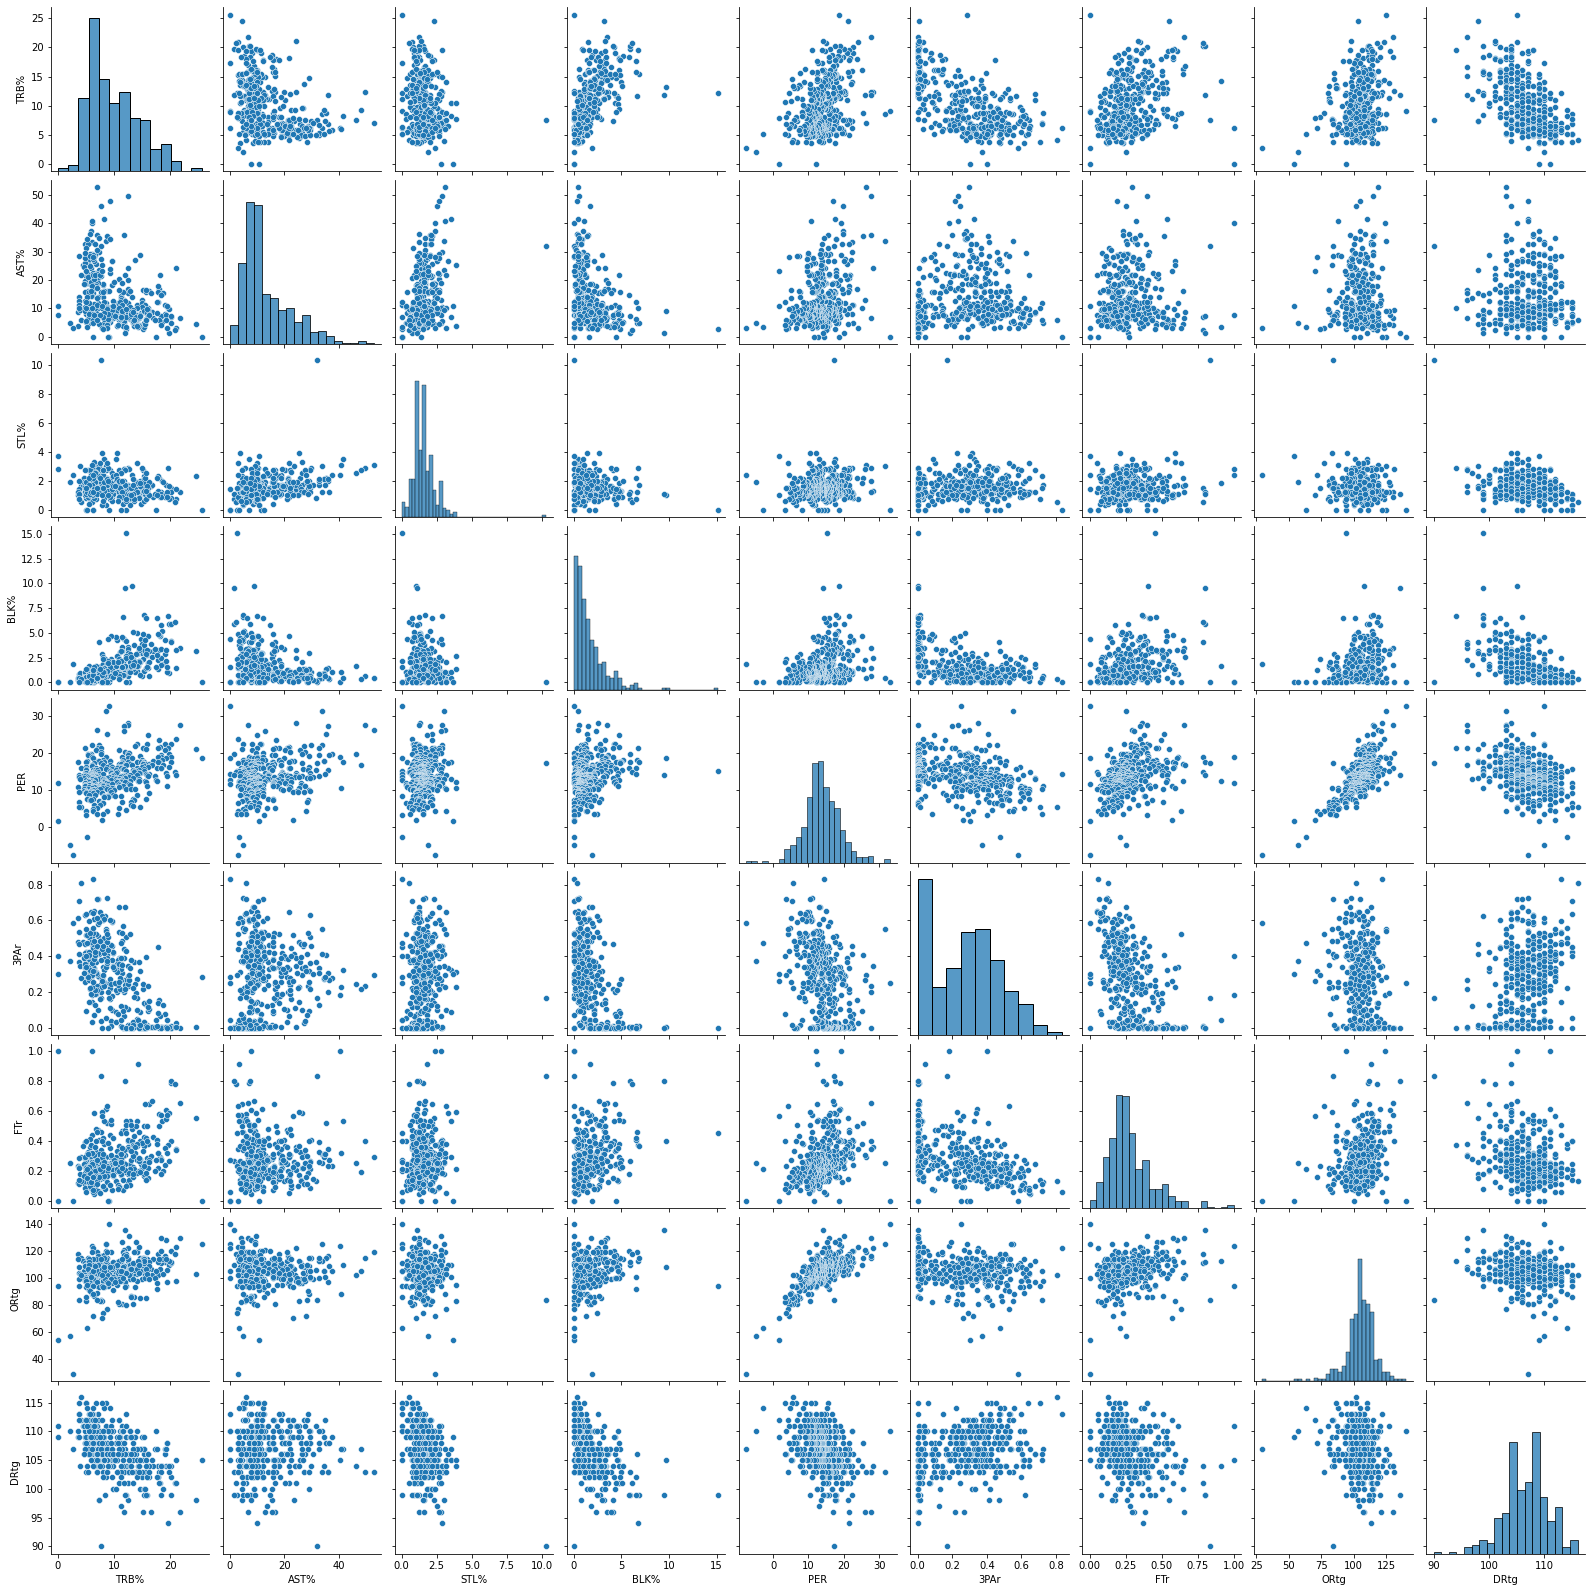

In [303]:
sns.pairplot(
    season_15_16,
    x_vars=["TRB%", "AST%", "STL%", "BLK%", "PER", "3PAr", "FTr", "ORtg", "DRtg"],
    y_vars=["TRB%", "AST%", "STL%", "BLK%", "PER", "3PAr", "FTr", "ORtg", "DRtg"],
    #hue = "SALARY_CATEGORY"
)
plt.show()

## **Comparison of performance of between players** using the "Radar plot"

- Since many features are used to take into account all aspects of the player performance. 
- We would like to visualize and compare main features at same time between the player with highest and the one with lowest salary. 

It turns out that the area generated by performance features for higher salary players would be larger than that of lower salary players. This nature is clear since higher the salary, one player has, the better he is, and hence the better skills, he posseses.     

In [304]:
columns_to_plot = ["AST%", "STL%", "BLK%", "USG%", "TRB%"]
season_15_16_sort = season_15_16.sort_values(by="SALARY_CATEGORY", ascending=False) 
player_hightest_salary = dict(season_15_16_sort.iloc[0][columns_to_plot])
player_lowest_salary = dict(season_15_16_sort.iloc[-1][columns_to_plot])

In [305]:
def get_values_and_angles(player_info: dict):
    Attributes = list(player_info.keys())
    AttNo = len(Attributes)
    
    values = list(player_info.values())
    values += values [:1]
    
    angles = [n / float(AttNo) * 2 * np.pi for n in range(AttNo)]
    angles += angles [:1]
    return angles, values, Attributes

In [306]:
def plot_rada(player_info: dict, label):
    
    angles, values, Attributes = get_values_and_angles(player_info)

    ax = plt.subplot(111, polar=True)

    #Add the attribute labels to our axes
    plt.xticks(angles[:-1], Attributes)

    #Plot the line around the outside of the filled area, using the angles and values calculated before
    ax.plot(angles,values)

    #Fill in the area plotted in the last line
    ax.fill(angles, values, 'teal', alpha=0.1)

    #Give the plot a title and show it
    ax.set_title(label)
    plt.show()

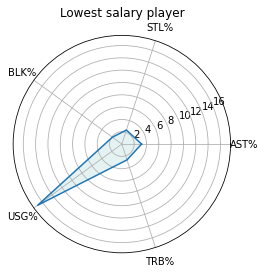

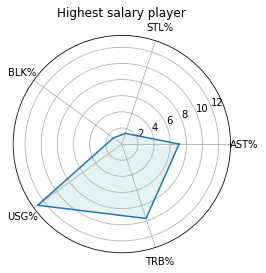

In [307]:
plot_rada(player_lowest_salary, "Lowest salary player")
plot_rada(player_hightest_salary, "Highest salary player")

In [308]:
def plot_rada_2players(player1_info: dict, player2_info: dict, labels):
    
    angles1, values1, Attributes = get_values_and_angles(player1_info)
    angles2, values2, _ = get_values_and_angles(player2_info)
    

    #Create the chart as before, but with both Ronaldo's and Messi's angles/values
    ax = plt.subplot(111, polar=True)
    ax.set_title("Comparison of performances between the lowest and highest salary players")

    plt.xticks(angles1[:-1], Attributes)

    ax.plot(angles1,values1)
    ax.fill(angles1, values1, 'blue', alpha=0.1)

    ax.plot(angles2,values2)
    ax.fill(angles2, values2, 'red', alpha=0.1)

    #Rather than use a title, individual text points are added
    plt.figtext(0.2,0.85, labels[0], color="red")
    plt.figtext(0.2,0.82,"vs")
    plt.figtext(0.2,0.80, labels[1], color="blue")
    plt.show()

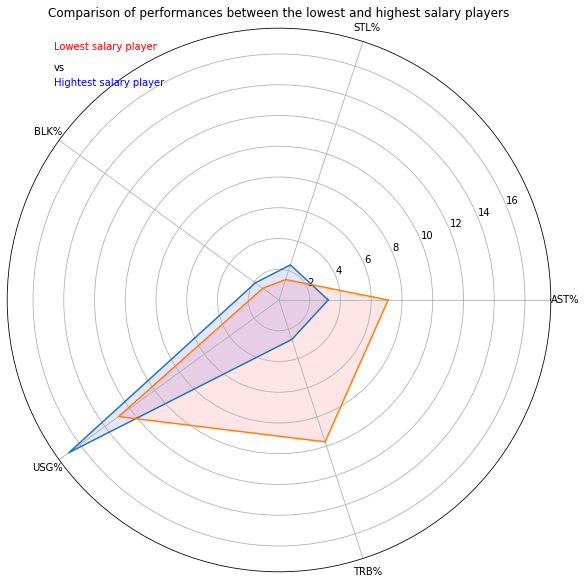

In [309]:
plt.figure(figsize=(10,10))
plot_rada_2players(player_lowest_salary, player_hightest_salary, ["Lowest salary player", "Hightest salary player"])
plt.show()

## **Relationship between college and salary**

Here we have plotted the relationship between colleges and the salary of the players. 

The plots below will show that the players who went to college with a good basketball team such as "University of Kentucky" or "Arizona State University" did not always have players with high salary.

In [310]:
# Duplicate the original dataset and create a new dataframe of salaries to remove "Missing" values
college_clean = cp.deepcopy(season_15_16)

index_names = college_clean[ college_clean['College'] == 'Missing'].index
college_clean.drop(index_names, inplace = True)

college_clean.head()

,Season,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,Pos,Ht,Wt,Birth Date,College,RK,SALARY,seniority,SALARY_CATEGORY,seniority_category
1,2015-16,27.0,GSW,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,G,190.50,185,"March 14, 1988",Davidson College,55,11370786,6,High,Senior
2,2015-16,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622,8,High,Senior
4,2015-16,27.0,OKC,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218,7,High,Senior
6,2015-16,30.0,LAC,74,74.0,2420.0,26.2,0.295,0.294,1.8,12.0,7.0,52.7,3.1,0.4,13.4,27.1,119.0,103.0,9.2,3.5,12.7,0.253,7.3,0.5,7.8,6.0,North Carolina,Black,G,182.88,175,"May 6, 1985",Wake Forest University,6,21468695,10,High,Senior
7,2015-16,24.0,SAS,72,72.0,2380.0,26.0,0.267,0.306,4.7,18.4,11.8,13.0,2.8,2.3,7.8,25.8,121.0,96.0,8.3,5.5,13.7,0.277,5.5,2.8,8.3,6.2,California,Black,F,200.66,230,"June 29, 1991",San Diego State University,18,16407500,4,High,Junior


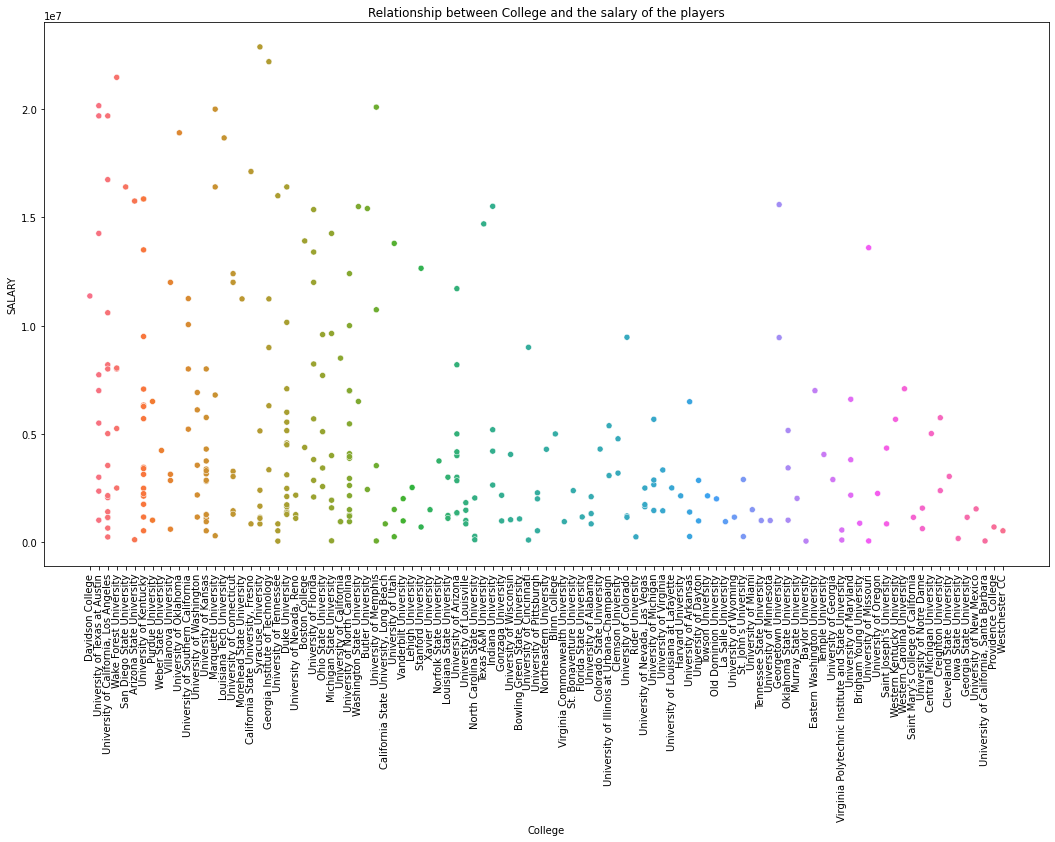

In [311]:
#Plot to see the relationship between College and the salary
plt.figure(figsize=(18,10))
sns.scatterplot('College', 'SALARY', data=college_clean, hue='College')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Relationship between College and the salary of the players')
plt.xticks(rotation = 90)
plt.legend([],[], frameon=False)
plt.show()

In order to finalize if the assumption is false, we also tried to see the list of colleges of the top 20 players who have high salaries during this season.

In [312]:
# Duplicate the original dataset and create a new dataframe of salaries with descending order
college_asc = cp.deepcopy(college_clean)
college_asc = college_asc.sort_values(by=['SALARY'], ascending=False)
college_asc.head()

,Season,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,Pos,Ht,Wt,Birth Date,College,RK,SALARY,seniority,SALARY_CATEGORY,seniority_category
31,2015-16,31.0,NYK,72,72.0,2530.0,20.3,0.237,0.308,4.3,19.5,12.0,21.9,1.3,1.1,10.6,29.7,107.0,107.0,3.9,2.5,6.4,0.121,2.8,-0.2,2.6,2.9,New York,Black,F,203.20,240,"May 29, 1984",Syracuse University,3,22875000,12,High,Senior
33,2015-16,31.0,MIA,53,53.0,1778.0,20.2,0.289,0.349,3.2,21.1,12.4,12.1,1.0,1.5,8.1,24.7,114.0,104.0,4.1,2.3,6.4,0.172,2.3,-0.3,2.1,1.8,Texas,Black,F-C,210.82,235,"March 24, 1984",Georgia Institute of Technology,5,22192730,12,High,Senior
6,2015-16,30.0,LAC,74,74.0,2420.0,26.2,0.295,0.294,1.8,12.0,7.0,52.7,3.1,0.4,13.4,27.1,119.0,103.0,9.2,3.5,12.7,0.253,7.3,0.5,7.8,6.0,North Carolina,Black,G,182.88,175,"May 6, 1985",Wake Forest University,6,21468695,10,High,Senior
2,2015-16,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622,8,High,Senior
193,2015-16,27.0,CHI,66,66.0,2097.0,13.5,0.143,0.171,2.4,8.8,5.6,25.5,1.1,0.5,13.4,27.3,96.0,110.0,-0.8,1.2,0.4,0.009,-1.2,-2.1,-3.3,-0.7,Illinois,Black,G,190.50,190,"October 4, 1988",University of Memphis,8,20093064,7,High,Senior


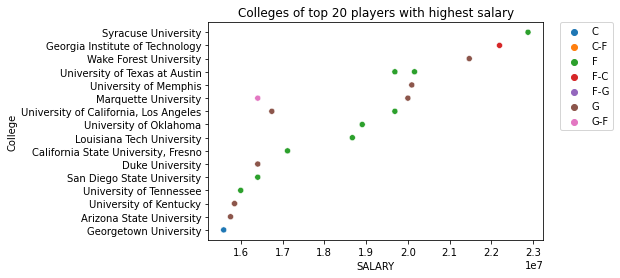

In [313]:
sns.scatterplot(
    x='SALARY',
    y='College',
    data=college_asc.nlargest(20, 'SALARY'),
    hue='Pos'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Colleges of top 20 players with highest salary')
plt.show()

From the plot above, we can see that the top 20 players who have the highest salary did not come from the colleges that has a good basketball team, and therefore the assuption we made above is false.

# Adding other seasons

In [314]:
merge_14_15 = pd.read_csv(os.path.join(data_path, "preprocessed_data", "merge_14_15.csv"))
merge_13_14 = pd.read_csv(os.path.join(data_path, "preprocessed_data", "merge_13_14.csv"))

In order to be more accurate, we integrated the inflation factor in the salary column for the different years. We take as reference the year 2016. According to this website: https://stats.areppim.com/calc/calc_usdlrxdeflator.php, 1.00 US Dollars of 2014 are worth 1.02 US Dollars of 2016 and 1.00 US Dollars of 2015 are worth 1.01 US Dollars of 2016.

In [315]:
merge_15_16['SALARY'] = merge_15_16['SALARY'] * 1.0
merge_14_15['SALARY'] = merge_14_15['SALARY'] * 1.01
merge_13_14['SALARY'] = merge_13_14['SALARY'] * 1.02

In [316]:
final_df = pd.concat([merge_15_16, merge_14_15, merge_13_14]).reset_index(drop=True)
print(final_df.shape)

(1163, 43)


In [317]:
final_df.head()

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
0,Thanasis Antetokounmpo,2015-16,23.0,NYK,NBA,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,2015-2016,416,"Thanasis Antetokounmpo, SF",New York Knicks,30888.0
1,Stephen Curry,2015-16,27.0,GSW,NBA,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,2015-2016,55,"Stephen Curry, PG",Golden State Warriors,11370786.0
2,Kevin Durant,2015-16,27.0,OKC,NBA,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,2015-2016,7,"Kevin Durant, SF",Oklahoma City Thunder,20158622.0
3,Boban Marjanovic,2015-16,27.0,SAS,NBA,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,2015-2016,315,"Boban Marjanovic, C",San Antonio Spurs,1200000.0
4,Russell Westbrook,2015-16,27.0,OKC,NBA,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",2015-2016,16,"Russell Westbrook, PG",Oklahoma City Thunder,16744218.0


# Preprocessing

The columns **NAME** and **SEASON** and **TEAM** are repeated twice so we can remove the duplicated columns. Also, we can remove the column of the league because they all play for the NBA for these seasons. Finally, we drop the column of the player's names because it's a categorical column that takes a different value for each row.

In [318]:
# We made a deepcopy of the dataset to keep the original untouched since we will modify this one in preprocessing
M = cp.deepcopy(final_df)
to_drop = ['Lg', 'NAME', 'Player', 'SEASON', 'TEAM']
M.drop(to_drop, axis=1, inplace=True)
M.head()

,Season,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,23.0,NYK,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,27.0,GSW,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,27.0,SAS,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,27.0,OKC,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


We observe that our dataset contains a lot of important categorical features like the basketball team of the players and their colleges... So it's important to find the most efficient way to encode them. During the week of the data camp, we saw many encoding techniques and that this step is critical in our preprocessing since it can influence significantly our model performance.

We decided to use the Count Ordinal Encoder for all categorical variables because:

- We could've used the Ordinal encoding, but we didn't because it can introduce bias and give for example a race superiority over another for the race column. 


- We didn't use Count Encoding because it can be a source of collisions. 


- We didn't use One hot encoding because during the week of the data camp we saw that it's mostly used with linear algorithms. Moreover, it can lead to sparse representations if we have many categories like in **Place_of_Birth** and **College**.


- Finally,  we chose the Count Ordinal Encoding because it works for both linear and non linear algorithms. 


In [319]:
from helpers import CountOrdinalEncoder
## We use the code from the Datacamp week for the CountOrdinalEncoder
coe = CountOrdinalEncoder()
new_c = coe.fit_transform(pd.DataFrame(M['Tm']))
new_c = new_c.reshape(len(new_c),)
M.drop('Tm', axis=1, inplace=True)
M.insert(1, 'Tm', new_c)

The initial height values are feet mixed with inches and we want a more homogenous value, so we convert it to centimeters

In [320]:
# Converting height from feet to centimeters
from helpers import convert_height
new_c = np.array(M['Ht'].apply(convert_height))
new_c = new_c.reshape(len(new_c),)
M.drop('Ht', axis=1, inplace=True)
M.insert(32, 'Ht', new_c)

The initial dataframe contained the first year in which the player started playing (*From*) up to the year of the season (*To*). In order to better use this information, we came up with the idea of taking the difference. We can interpret this new column as the seniority of the player. 

In [321]:
# The "From" and "To" columns are redundant, we can just convert them to a column seniority
duration = M['To'] - M['From']
M.insert(29, 'seniority', duration)
M.drop('To', axis=1, inplace=True)
M.drop('From', axis=1, inplace=True)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [322]:
# Encoding the race into a numerical value
pd.Categorical(M['Race']).categories

Index(['Black', 'Black and White', 'Others', 'White'], dtype='object')

In [323]:
new_c = coe.fit_transform(pd.DataFrame(M['Race']))
new_c = new_c.reshape(len(new_c),)
M.drop('Race', axis=1, inplace=True)
M.insert(28, 'Race', new_c)
M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


Now we will work on the Place of Birth of the players

In [324]:
print(np.sort(M['Place_of_Birth'].unique()))
print(len(M['Place_of_Birth'].unique()))

['Alabama' 'Alaska' 'Argentina' 'Arizona' 'Arkansas' 'Arkansas '
 'Australia' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'California'
 'California ' 'Cameroon' 'Canada' 'Cape Verde' 'Colorado' 'Congo'
 'Croatia' 'Czech Republic' 'Democratic Republic of the Congo'
 'District of Columbia' 'Dominican Republic' 'Dominican Repulic' 'England'
 'Florida' 'Florida ' 'France' 'French Guiana' 'Georgia' 'Georgia '
 'Germany' 'Greece' 'Haiti' 'Idaho' 'Illinois' 'Illinois ' 'Indiana'
 'Indiana ' 'Iowa' 'Israel' 'Italy' 'Kansas' 'Kentucky' 'Kentucky '
 'Latvia' 'Lithuania' 'Louisiana' 'Macedonia' 'Maryland' 'Maryland '
 'Massachusetts' 'Mexico' 'Michigan' 'Michigan ' 'Minnesota' 'Minnesota '
 'Mississippi' 'Mississippi ' 'Missouri' 'Missouri ' 'Montenegro' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'New Zealand'
 'New zealand' 'Nigeria' 'North Carolina' 'North Carolina ' 'North Dakota'
 'Ohio' 'Ohio ' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Pennsylvania '
 'Poland' 'Puerto Rico' 'Re

We notice that some states and countries appeared twice because of lower/uppercase differences and extra spaces at the end.
For example, we have `'Missouri'` and  `'Missouri '`, `'Serbia'` and `'serbia'` etc. So, we decided to add some preprocessing to put it all in the same format.

In [325]:
def correct_names(s):
    s = s.lower().strip() #lowercase and remove the extra space at the end
    return s

M['Place_of_Birth'] = M['Place_of_Birth'].apply(lambda s: correct_names(s))

There's also a misspell in the name of **Wisconsin** that need to be corrected. Also, **Russia** and **Russian Federation** mean the same country so we need to correct it. 

In [326]:
# Changing Federation of Russia to Russia
indices = np.where(M['Place_of_Birth'] == "russian federation")[0]
M['Place_of_Birth'][indices] = "russia"

# Correcting Wisconsin
indices = np.where(M['Place_of_Birth'] == "wisvonsin")[0]
M['Place_of_Birth'][indices] = "wisconsin"

print(np.sort(M['Place_of_Birth'].unique()))
print(len(M['Place_of_Birth'].unique()))

['alabama' 'alaska' 'argentina' 'arizona' 'arkansas' 'australia' 'belgium'
 'bosnia and herzegovina' 'brazil' 'california' 'cameroon' 'canada'
 'cape verde' 'colorado' 'congo' 'croatia' 'czech republic'
 'democratic republic of the congo' 'district of columbia'
 'dominican republic' 'dominican repulic' 'england' 'florida' 'france'
 'french guiana' 'georgia' 'germany' 'greece' 'haiti' 'idaho' 'illinois'
 'indiana' 'iowa' 'israel' 'italy' 'kansas' 'kentucky' 'latvia'
 'lithuania' 'louisiana' 'macedonia' 'maryland' 'massachusetts' 'mexico'
 'michigan' 'minnesota' 'mississippi' 'missouri' 'montenegro' 'nevada'
 'new hampshire' 'new jersey' 'new mexico' 'new york' 'new zealand'
 'nigeria' 'north carolina' 'north dakota' 'ohio' 'oklahoma' 'oregon'
 'pennsylvania' 'poland' 'puerto rico' 'republic of the congo'
 'rhode island' 'russia' 'senegal' 'serbia' 'slovenia' 'south africa'
 'south carolina' 'south dakota' 'south sudan' 'spain' 'sweden'
 'switzerland' 'tennessee' 'texas' 'turkey' 'u.s. v

We noticed that we have a mix between states of the USA and countries of the world as places of birth of the players. So, we will add another column to specify if it's a state of the USA or an actual country. This column will be categorical and it will take 1 if the place of birth is a state of the USA and 0 if it's a country of the world.

In [327]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
          'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
          'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
          'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',
          'South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
          'Wisconsin','Wyoming']
states = [state.lower() for state in states]

In [328]:
M.insert(28,'state_or_country',M['Place_of_Birth'].isin(states) * 1)

# We encode the place of birth by count ordinal encoding
new_c = coe.fit_transform(pd.DataFrame(M['Place_of_Birth']))
new_c = new_c.reshape(len(new_c),)
M.drop('Place_of_Birth', axis=1, inplace=True)
M.insert(27, 'Place_of_Birth', new_c)
M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [329]:
print('All possible positions are:', list(pd.Categorical(M['Pos']).categories))

# Encoding positions
new_c = coe.fit_transform(pd.DataFrame(M['Pos']))
new_c = new_c.reshape(len(new_c),)
M.drop('Pos', axis=1, inplace=True)
M.insert(31, 'Pos', new_c)
M.head()

All possible positions are: ['C', 'C-F', 'F', 'F-C', 'F-G', 'G', 'G-F']


,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [330]:
print('All possible colleges are:', list(pd.Categorical(M['College']).categories))
print('\n\nNumber of colleges: ', len(list(pd.Categorical(M['College']).categories)))

All possible colleges are: ['Arizona State University', 'Baylor University', 'Belmont University', 'Blinn College', 'Boston College', 'Bowling Green State University', 'Brigham Young University', 'Bucknell University', 'Butler University', 'California State University, Fresno', 'California State University, Long Beach', 'Central Michigan University', 'Clemson University', 'Cleveland State University', 'Colorado State University', 'Creighton University', 'Davidson College', 'DePaul University', 'Duke University', 'Duquesne University', 'Eastern Washington University', 'Florida State University', 'Georgetown University', 'Georgia Institute of Technology', 'Georgia State University', 'Gonzaga University', 'Harvard University', 'Indiana University', 'Indiana University-Purdue University Indianapolis', 'Iowa State University', 'Kansas State University', 'La Salle University', 'Lehigh University', 'Louisiana State University', 'Louisiana Tech University', 'Marquette University', 'Marshall Un

Now, we will encode the college column using the COE as before. In fact, we believe this feature can be important since colleges with good basketball teams tend to offer scholarships to high school students that have good performance in this sport. Consequently, a player with a high salary is more likely to have studied in a college with a good basketball team. This assumption is to be confirmed by plots shown later in this notebook.

In [331]:
# Treating NAN values of this column
# We will just replace all this players of whom we don't have info about the college with "Missing"      
M['College'][np.where(M['College'].isna() == True)[0]] = "Missing"
new_c = coe.fit_transform(pd.DataFrame(M['College']))
new_c = new_c.reshape(len(new_c),)
M.drop('College', axis=1, inplace=True)
M.insert(34, 'College', new_c)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,Birth Date,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,125.0,"July 17, 1992",416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,48.0,"March 14, 1988",55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,117.0,"September 29, 1988",7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,125.0,"August 15, 1988",315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,120.0,"November 12, 1988",16,16744218.0


We will drop **Date of Birth**, since it's redundant because we already have the age of each player stored in a column.
We also drop the column **RK**. In fact, this column represents the ranking of the players based on their salary, so we cannot use it as a feature.

In [332]:
M.drop('Birth Date', axis=1, inplace=True)
M.drop('RK', axis=1, inplace=True)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,125.0,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,48.0,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,117.0,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,125.0,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,120.0,16744218.0


In [333]:
M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            1163 non-null   object 
 1   Tm                1163 non-null   float64
 2   Age               1163 non-null   float64
 3   G                 1163 non-null   int64  
 4   GS                1163 non-null   float64
 5   MP                1163 non-null   float64
 6   PER               1163 non-null   float64
 7   3PAr              1161 non-null   float64
 8   FTr               1161 non-null   float64
 9   ORB%              1163 non-null   float64
 10  DRB%              1163 non-null   float64
 11  TRB%              1163 non-null   float64
 12  AST%              1163 non-null   float64
 13  STL%              1163 non-null   float64
 14  BLK%              1163 non-null   float64
 15  TOV%              1161 non-null   float64
 16  USG%              1163 non-null   float64


We notice that we have NaN values in our dataframe. Let's investigate this.

In [334]:
M[M.isna().any(axis=1)]

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,SALARY
285,2015-16,19.0,21.0,3,0.0,6.0,10.8,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,NaN,95.0,0.0,0.0,0.0,0.116,-5.3,5.8,0.5,0.0,68.0,1,2.0,0,5.0,205.74,230,76.0,1646400.0
745,2014-15,23.0,32.0,2,0.0,19.0,4.3,NaN,NaN,0.0,6.2,3.0,14.0,0.0,0.0,NaN,0.0,214.0,119.0,0.0,0.0,0.0,0.009,-5.6,-2.1,-7.7,0.0,76.0,0,3.0,9,5.0,208.28,249,94.0,1515000.0


We see that all the missing values are located only in two rows. Morever, since the missing values are key performance features for the two players, replacing these values with the mean (or median) might induce predictions errors. Instead, we decided to simply drop these lines.

In [335]:
ind = np.where(M['3PAr'].isna())[0]
M.drop(ind, axis=0, inplace=True)
M.reset_index(drop=True, inplace=True)

The preprocessing step is now over, the next step will be the data analysis which will help us select the features for salary prediction.

# Data Analysis

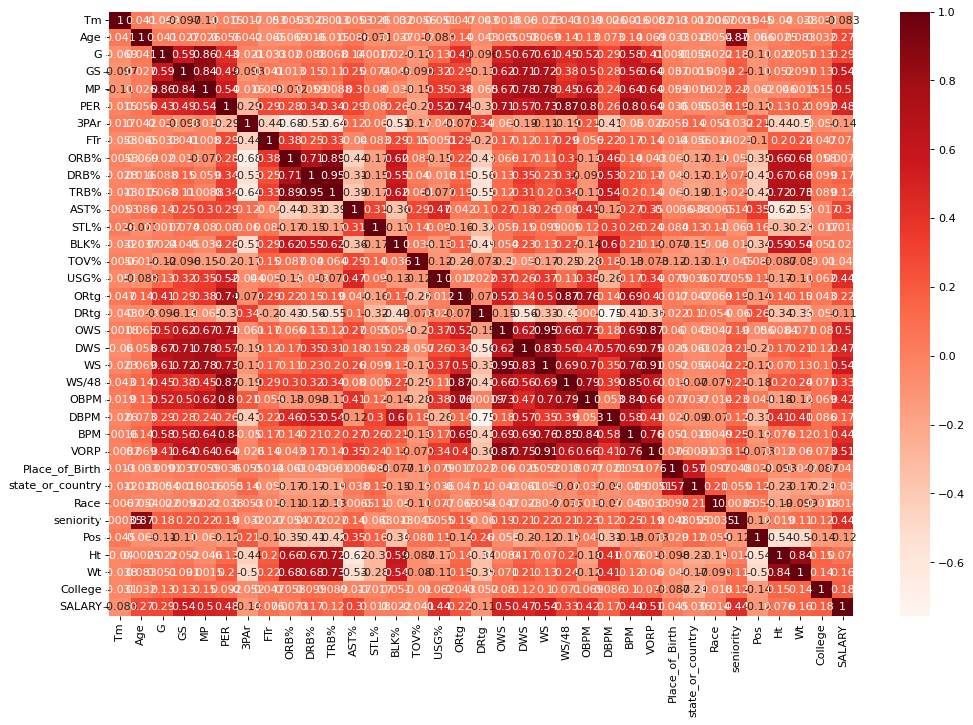

In [336]:
M[M.columns].corr()

plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(M[M.columns].corr(), annot=True, cmap = 'Reds')
plt.show()

The high correlations suggest that many of the columns contain redundant information, i.e. information from one column is contained in other columns. We can only use a subset of the columns for training and predicting. However, we chose not drop any column since a regularized model can do feature selection on its own.

# First experiment

At first, we wanted to see what features are the most discriminative via a Lasso regression. To do so, we decided at first to limit ourselves to one season. Afterwards, we will code a more sophisticated way  of splitting which will be more adapted to our dataframe.

In [337]:
# Splitting into tagert and learning data
M_15_16 = M[M['Season']=='2015-16']
Y = cp.deepcopy(M_15_16['SALARY'])
col = list(set((M_15_16.columns))- set(['SALARY', 'Season']))
X = cp.deepcopy(M_15_16[col])

Y = np.array(Y).reshape(-1,1)

# Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

scaler = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Model 1: Lasso Regression

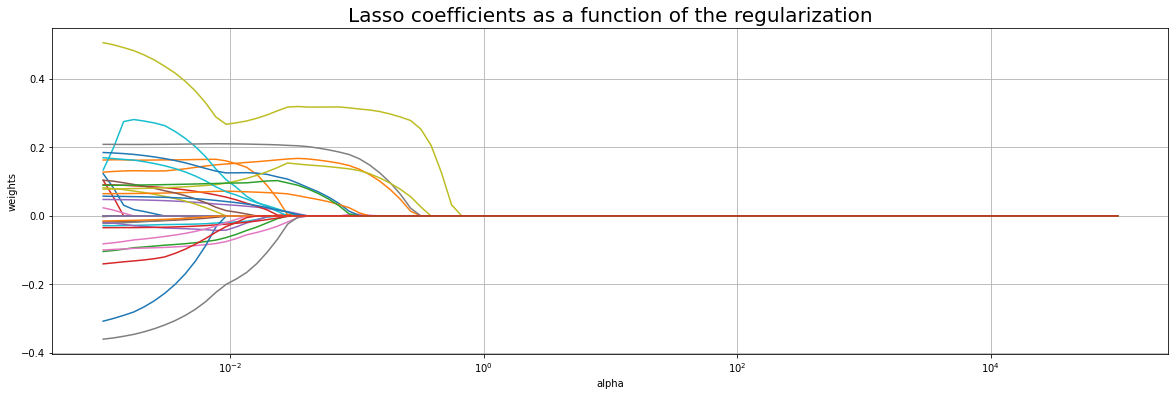

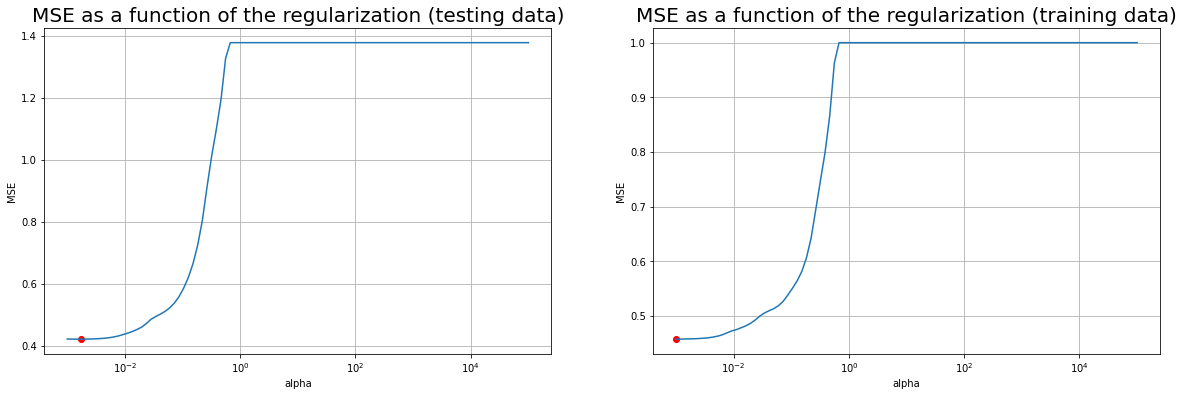

In [338]:
n_lasso = 100
weights_lasso, MSE_lasso, MSE_lasso_app = list(), list(), list()
alphas_lasso = np.logspace(-3, 5, n_lasso)
for a in alphas_lasso:
    lasso = Lasso(alpha = a)
    lasso.fit(X_train_scaled, y_train_scaled)
    weights_lasso.append(lasso.coef_)
    y = lasso.predict(X_test_scaled)
    y_app = lasso.predict(X_train_scaled)
    MSE_lasso.append(mean_squared_error(y, y_test_scaled))
    MSE_lasso_app.append(mean_squared_error(y_app, y_train_scaled))
weights_lasso = np.array(weights_lasso)

pl.figure(11, figsize=(20, 6))
ax = pl.gca()
for i in range(weights_lasso.shape[1]):
    ax.plot(alphas_lasso, weights_lasso[:,i])
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('weights')
pl.title('Lasso coefficients as a function of the regularization', fontsize = 20)
pl.grid()
pl.axis('tight')

pl.figure(12, figsize=(20, 6))
pl.subplot(1,2,1)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso)], np.amin(MSE_lasso), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (testing data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.subplot(1,2,2)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso_app)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso_app)], np.amin(MSE_lasso_app), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (training data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.show()

- The top plot represents the regularization path. This illustrates the fact that Lasso performs feature selection.


- The two bottom plots show the optimal $\lambda$ values for on test and train sets

In [339]:
alpha_optim_lasso = alphas_lasso[np.argmin(MSE_lasso)]
model_lasso_optim = Lasso(alpha = alpha_optim_lasso)
model_lasso_optim.fit(X_train_scaled, y_train_scaled)
print("\nThe value of alpha that gives the smallest MSE score is: {}".format(np.round(alpha_optim_lasso,5)))


The value of alpha that gives the smallest MSE score is: 0.00175


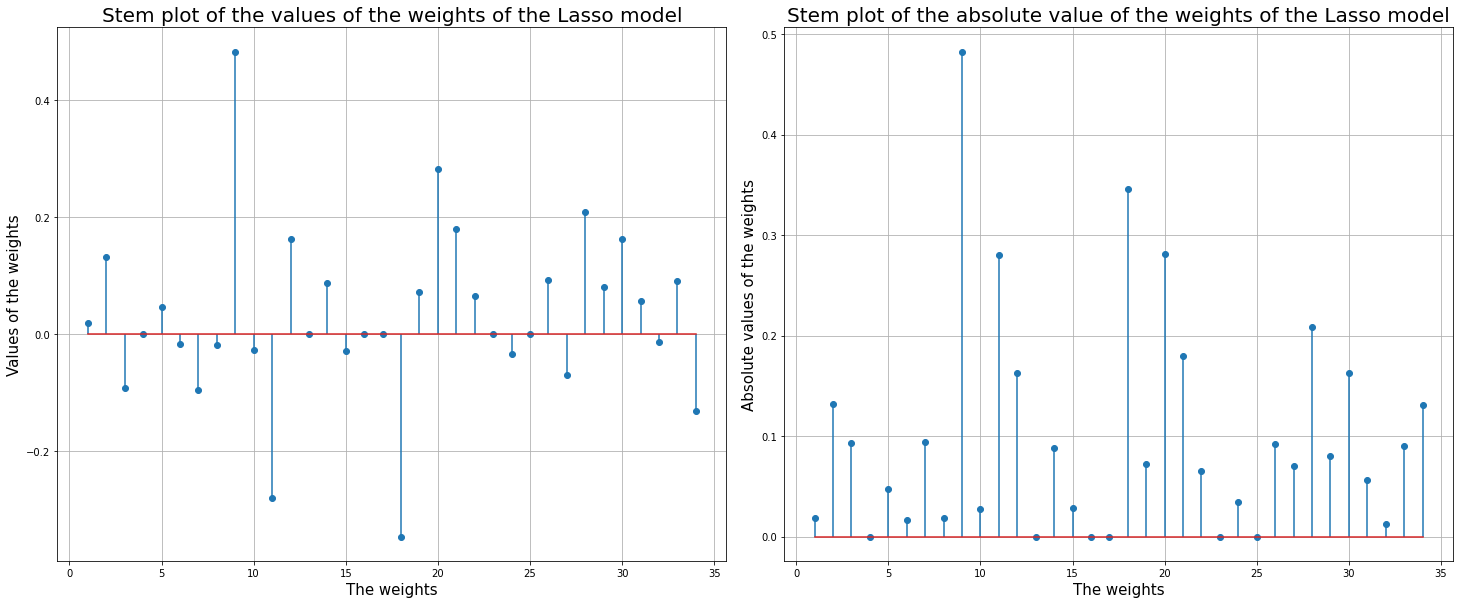

In [340]:
# Looking at the selection made by Lasso and use it to do variable selection and apply it to a non linear model
pl.figure(14, figsize = (20,8))
x = np.array([i+1 for i in range(model_lasso_optim.coef_.shape[0])])
pl.subplot(1,2,1)
pl.tight_layout(h_pad = 5, w_pad = 5)
pl.stem(x, model_lasso_optim.coef_, use_line_collection = True)
pl.title("Stem plot of the values of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Values of the weights",fontsize=15)
pl.grid()
pl.subplot(1,2,2)
pl.stem(x, np.abs(model_lasso_optim.coef_), use_line_collection = True)
pl.title("Stem plot of the absolute value of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Absolute values of the weights",fontsize=15)
pl.grid()

In [341]:
print('The corresponding features of the stem plot:\n', col)

The corresponding features of the stem plot:
 ['DBPM', 'USG%', 'BLK%', 'OBPM', 'Place_of_Birth', 'Pos', 'STL%', 'TOV%', 'WS', 'FTr', 'VORP', 'MP', 'OWS', 'Ht', '3PAr', 'WS/48', 'PER', 'G', 'ORB%', 'BPM', 'AST%', 'College', 'Age', 'Tm', 'TRB%', 'DRtg', 'DRB%', 'seniority', 'GS', 'DWS', 'Race', 'state_or_country', 'Wt', 'ORtg']


Now, we evaluate the performance of our first model on the test set. To do so, we chose the MSE, which is the standard metric for regression. Moreover, to relatively quantify the error made by the model, we used a scale-free metric such as the $R^2$ score.

In [342]:
y_predicted = model_lasso_optim.predict(X_test_scaled)
print("The MSE score is:", mean_squared_error(y_test_scaled, y_predicted))
print("The R2 score is:", r2_score(y_test_scaled, y_predicted))

The MSE score is: 0.4220018311221486
The R2 score is: 0.6815851018707573


# Model 2: XGBoost

We also wanted to use a non linear model because they are generally more performant than linear models like Lasso regression.

In [343]:
model_rd = XGBRegressor()
model_rd.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

y_pred = model_rd.predict(X_test_scaled)
print("The MSE score is:", mean_squared_error(y_test_scaled, y_pred))
print("The R2 score is:", r2_score(y_test_scaled, y_pred))

In our case, the Lasso regression is more accurate than the XGBRegressor with default parameters.

# Cross validation

We decided to define our own cross validation class. Instead of splitting our data randomly as we often do in regular dataframes, we took into consideration the season information. Each time we keep aside one season for the test and train the model on the remaining seasons. 

The aim of this type of cross validation is to test the robustness of our model for when we change seasons.

In [344]:
from sklearn.model_selection import BaseCrossValidator

class SeasonSplit(BaseCrossValidator):

    def __init__(self, season_col='Season'):  
        self.season_col = season_col

    def get_n_splits(self, X, y=None, groups=None):
        return len(X.reset_index()[self.season_col].unique())

    def split(self, X, y, groups=None):
        n_splits = self.get_n_splits(X, y, groups)
        X = X.reset_index()
        season_names = X[self.season_col].unique()
        for i in range(n_splits):
            test_season = season_names[i]
            
            idx_test = list(X[X[self.season_col]==test_season].index)
            
            idx_train = list(set(X.index) - set(idx_test))
            yield (
                idx_train, idx_test
            )


We now test our splitter that performs cross validation on seasons from 2013-14 to 2015-16 and as a regressor we use XGBoost.

In [345]:
features = list(set((M.columns))- set(['SALARY']))
X, y = M[features], M['SALARY']

In [346]:
X = X.reset_index()

In [347]:
X = X.set_index(['index', 'Season'])

In [348]:
from sklearn.model_selection import cross_val_score

In [349]:
model_rd = XGBRegressor(random_state=0)
season_cv = SeasonSplit()
print(cross_val_score(model_rd, X, y, cv=season_cv, scoring='r2'))

[0.47621902 0.59243975 0.50958252]


In [351]:
train_idx, test_idx = next(season_cv.split(X,y))
train = M.iloc[train_idx]
test = M.iloc[test_idx]

train.to_csv(os.path.join(data_path, "train", "train.csv"), index=False)
test.to_csv(os.path.join(data_path, "test", "test.csv"), index=False)

# **Application of this topic**

From the result and data analysis we have obtained during the project trial, we could think of several possible application of this topic.

- Provide "Salary prediction system" to coaches or basketball team owners:
> - By using the predicted results obtained by the model, we could provide the system to coaches or basketball team owners when players need to sign the new contract for the new upcoming seasons. This will help the coaches or basketball team owners when newly negotiating the player's salaries for the upcoming seasons and thus prevent from the coaches or basketball team owners to pay overvalued salaries.

- Provide "Salary prediction system" to basketball players:
> - By using the predicted results obtained by the model, we could provide the system to basketball players when players need to sign the new contract for the new upcoming seasons. This will help the players when newly negotiating their salaries for the upcoming seasons and thus prevent from the players to receive undervalued salaries.